In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth, tilt_distance_LI, compute_tilt_data, bearing


In [2]:
sample_eddies = [66, 425, 871, 1780, 31, 182, 1602, 2128]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]
# with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies_sample.pkl', 'rb') as f:
#     dic_sample = pickle.load(f)
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]

df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")

df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)


In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [4]:
df_sample = df_eddies[df_eddies.Eddy.isin(sample_eddies)]
df_sample.TiltDis.min(), df_sample.TiltDis.max(), df_sample.TiltDis.mean()


(np.float64(0.3190352011999737),
 np.float64(74.83647909480015),
 np.float64(13.144270022379485))

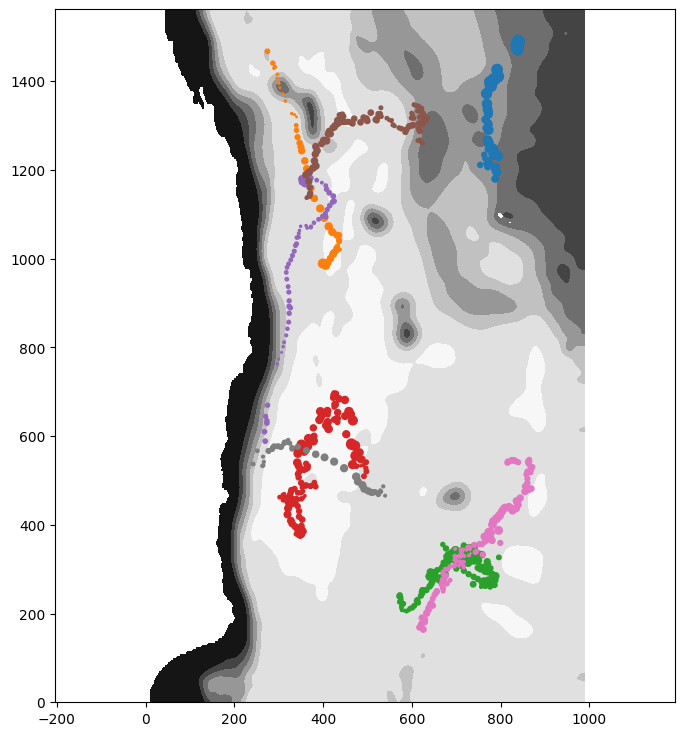

In [5]:
plt.figure(figsize=(8,9))
plt.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='Greys_r')

for eddy in sample_eddies:

    df = df_eddies[df_eddies.Eddy==eddy]
    plt.scatter(df.xc, df.yc, s=df.TiltDis)
plt.axis('equal'); 
plt.show()
    

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

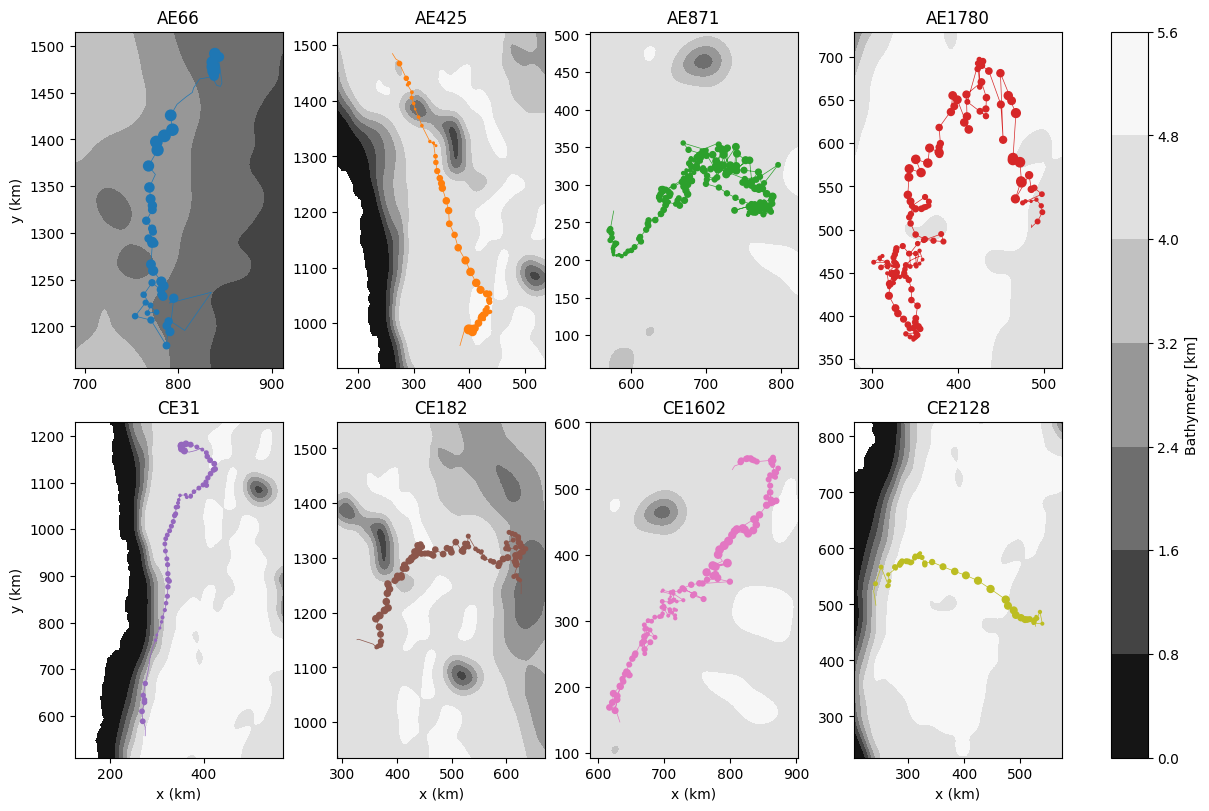

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(12,8), constrained_layout=True)
mappable = None
for e, eddy in enumerate(sample_eddies):
    ax = axs[e//4, e%4]
    m = ax.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='Greys_r')
    if mappable is None:
        mappable = m
    df = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(df.xc, df.yc, lw=.5, color=colors[e])
    ax.scatter(df.xc, df.yc, s=df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==eddy].Cyc.iloc[0]
    ax.axis('equal'); ax.set_title(f'{cyc}{eddy}')
    ax.set_xlim(df.xc.min(), df.xc.max()); ax.set_ylim(df.yc.min(), df.yc.max())

    if e // 4 == 1:
        ax.set_xlabel('x (km)')
    if e % 4 == 0:
        ax.set_ylabel('y (km)')

# shared colourbar on the far right
cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(), location='right')
cbar.set_label('Bathymetry [km]')


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

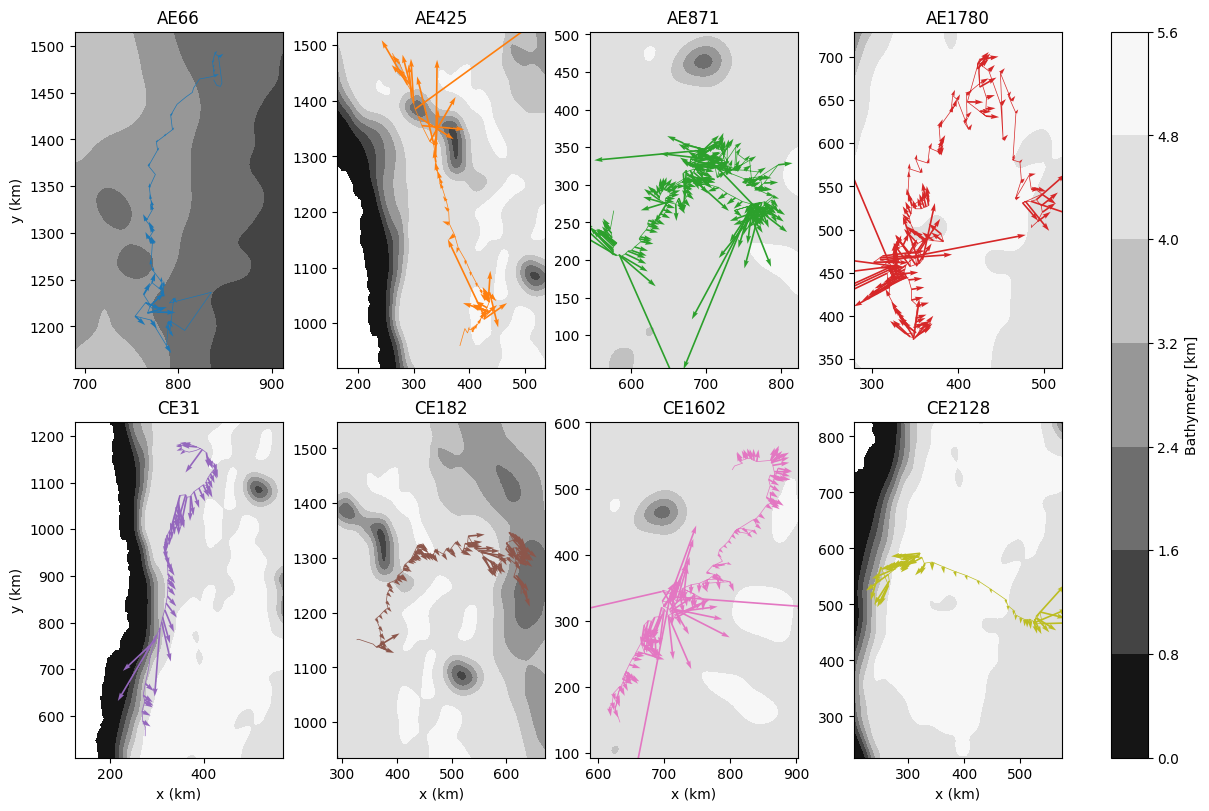

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(12,8), constrained_layout=True)
mappable = None
for e, eddy in enumerate(sample_eddies):
    ax = axs[e//4, e%4]
    m = ax.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='Greys_r')
    if mappable is None:
        mappable = m
    df = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(df.xc, df.yc, lw=.5, color=colors[e])

    theta = np.deg2rad(df.TiltDir.to_numpy())  # bearing from north, clockwise
    u = np.sin(theta)                          # x-component
    v = np.cos(theta)                          # y-component

    ax.quiver(df.xc, df.yc, u, v, color=colors[e],
               angles='xy', scale_units='xy', scale=.005*df.TiltDis.to_numpy(), width=0.008)
    
    cyc = df_eddies[df_eddies.Eddy==eddy].Cyc.iloc[0]
    ax.axis('equal'); ax.set_title(f'{cyc}{eddy}')
    ax.set_xlim(df.xc.min(), df.xc.max()); ax.set_ylim(df.yc.min(), df.yc.max())

    if e // 4 == 1:
        ax.set_xlabel('x (km)')
    if e % 4 == 0:
        ax.set_ylabel('y (km)')

# shared colourbar on the far right
cbar = fig.colorbar(mappable, ax=axs.ravel().tolist(), location='right')
cbar.set_label('Bathymetry [km]')

# plt.tight_layout()


In [8]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        if len(df):
            df2 = df.copy()
            cols = df2.columns.drop("Depth")
            # df2[cols] = df2[cols].sub(df2[cols].iloc[0])
    
            tmp = (df2[['x','y']] if not df2.empty else pd.DataFrame(index=[], columns=['x','y']))
            tmp = tmp.reindex(range(n))                     # pads with NaNs
            tmp.columns = [f'{eddy}_x_{d}', f'{eddy}_y_{d}']
            frames.append(tmp)

df_depths_orig = pd.concat([base, *frames], axis=1, copy=False)
df_depths_orig


Depth  Eddy66_x_0   Eddy66_y_0  Eddy66_x_1   Eddy66_y_1  Eddy66_x_2  \
0      1.783320  838.082945  1463.359042  841.944207  1458.453989  845.647270   
1      5.879627  838.449025  1462.889245  842.548504  1458.370782  846.492748   
2     10.725783  838.490020  1462.700349  842.953076  1458.517750  846.865130   
3     16.383097  838.643865  1462.945791  843.346376  1458.755273  847.123878   
4     22.925581  838.758631  1462.524487  843.581149  1458.630220  847.346424   
5     30.444118  838.899192  1462.704843  843.973783  1459.065805  848.195131   
6     39.052712  839.117184  1462.531297  844.352940  1459.700432  848.259160   
7     48.897638  839.480305  1462.474008  844.380259  1461.188048  848.335503   
8     60.170639  840.037014  1462.728148  844.866533  1462.552153  848.400615   
9     73.127842  841.301853  1463.629237  845.664766  1464.587517  848.068300   
10    88.116838  843.150953  1465.630382  847.367559  1468.758233  847.031000   
11   105.615538  843.953459  1469.997992  846.179321  1472.133580  844.362085   
12   126.288127  844.320437  1474.776243  844.828333  1476.891087  842.615098   
13   151.065954  842.906295  1478.397167  841.458909  1484.260520  841.299730   
14   181.264793  839.044829  1488.917853  841.639353  1485.658433  840.808058   
15   218.754856  839.028437  1506.495677  840.240047  1487.500094  839.348692   
16   266.206398  836.230589  1509.520093  830.895129  1498.158681  834.673463   
17   327.440851  834.919425  1530.184070  833.869490  1495.488760  835.198127   
18   407.922192  836.142636  1517.844166  832.273730  1496.841895  832.715351   
19   515.416489         NaN          NaN  827.792351  1497.694367  828.055555   
20   660.806374         NaN          NaN  822.163167  1499.951932  822.420808   
21   858.918478         NaN          NaN  810.381345  1548.331100         NaN   
22  1128.898331         NaN          NaN         NaN          NaN         NaN   
23  1492.971178         NaN          NaN         NaN          NaN         NaN   
24  1971.212518         NaN          NaN         NaN          NaN         NaN   
25  2568.677466         NaN          NaN         NaN          NaN         NaN   
26  3252.716389         NaN          NaN         NaN          NaN         NaN   
27  3930.053268         NaN          NaN         NaN          NaN         NaN   
28  4460.447022         NaN          NaN         NaN          NaN         NaN   
29  4748.917670         NaN          NaN         NaN          NaN         NaN   

     Eddy66_y_2  Eddy66_x_5   Eddy66_y_5  Eddy66_x_6  ...  Eddy2128_x_52  \
0   1457.132245  844.231507  1488.502854  839.416705  ...     253.084486   
1   1457.401894  844.139211  1487.952266  839.914092  ...     247.609623   
2   1457.608137  844.148262  1487.665062  840.245640  ...     246.281557   
3   1457.839066  844.146417  1487.423538  840.456378  ...     243.799958   
4   1458.110049  844.146634  1487.093842  840.741524  ...     243.910670   
5   1460.480151  844.096139  1486.861545  840.803457  ...     243.769833   
6   1462.114486  844.007418  1486.672237  840.963613  ...     243.670698   
7   1462.858759  843.788228  1486.529163  841.421390  ...     243.619169   
8   1465.279241  843.360048  1486.256158  841.036146  ...     243.535369   
9   1469.311099  842.087392  1485.073831  842.182898  ...     243.429020   
10  1475.939305  842.973422  1482.797650  842.049713  ...     243.337359   
11  1481.176921  843.394966  1479.472628  841.348263  ...     243.318669   
12  1481.159375  843.302714  1477.482948  846.575107  ...     243.575638   
13  1483.379701  842.758588  1475.496617  847.201260  ...     244.416773   
14  1483.990004  842.131112  1474.347401  846.657568  ...     244.688969   
15  1484.698124  841.245807  1472.910658  844.839343  ...     244.523550   
16  1486.089316  840.830920  1472.209457  843.040937  ...     244.625981   
17  1486.257402  839.996638  1472.531861  842.683844  ...     244.479538   
18  1483.630333  838.584992  1459.058726  844.162851  

### Eddy propogation


In [9]:
import re
import pandas as pd
from collections import defaultdict

df_pos = df_depths_orig.copy()

pat = re.compile(r'(Eddy\d+)_([xy])_(\d+)')

# Parse info
info = []
for c in df_pos.columns:
    m = pat.fullmatch(c)
    if m:
        eddy, comp, day = m.groups()
        info.append((eddy, comp, int(day), c))

cols_by_eddy = defaultdict(lambda: defaultdict(dict))
for eddy, comp, day, col in info:
    cols_by_eddy[eddy][day][comp] = col

# --- Collect diff columns here ---
td_frames = []   # each entry is a small DataFrame

for eddy, days in cols_by_eddy.items():
    day_nums = sorted(days.keys())

    for i in range(1, len(day_nums)):
        d_prev = day_nums[i-1]
        d_now  = day_nums[i]

        if 'x' not in days[d_prev] or 'y' not in days[d_prev]:
            continue
        if 'x' not in days[d_now] or 'y' not in days[d_now]:
            continue

        x0 = df_pos[days[d_prev]['x']]
        y0 = df_pos[days[d_prev]['y']]
        x1 = df_pos[days[d_now]['x']]
        y1 = df_pos[days[d_now]['y']]

        td = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        colname = f'{eddy}_diff_{d_now}'
        td_frames.append(td.rename(colname).to_frame())

# --- FINAL CONCAT (fast, no fragmentation) ---
out = pd.concat([df_pos[['Depth']], *td_frames], axis=1)
out


Depth  Eddy66_diff_1  Eddy66_diff_2  Eddy66_diff_5  Eddy66_diff_6  \
0      1.783320       6.242506       3.931880      31.402540       5.917076   
1      5.879627       6.101003       4.061503      30.640894       4.732460   
2     10.725783       6.116618       4.016412      30.179465       4.157451   
3     16.383097       6.298734       3.887024      29.733924       3.804659   
4     22.925581       6.198548       3.801036      29.159886       3.439282   
5     30.444118       6.244522       4.451983      26.697935       3.430482   
6     39.052712       5.952053       4.591972      24.923091       3.090524   
7     48.897638       5.065890       4.293626      24.103230       2.543450   
8     60.170639       4.832724       4.463939      21.574020       2.530317   
9     73.127842       4.466914       5.299924      16.859270       1.425467   
10    88.116838       5.250069       7.188955       7.968741       0.929921   
11   105.615538       3.084671       9.224119       1.959575       3.725707   
12   126.288127       2.174977       4.807981       3.740178       4.333377   
13   151.065954       6.039358       0.895087       8.016937       4.458274   
14   181.264793       4.165977       1.864057       9.732947       4.816831   
15   218.754856      19.034184       2.940332      11.939154       4.039412   
16   266.206398      12.551845      12.646951      15.184359       3.570761   
17   327.440851      34.711193       9.326481      14.540157       6.106680   
18   407.922192      21.355650      13.218941      25.262948      17.533583   
19   515.416489            NaN      16.345284      40.398507      11.110870   
20   660.806374            NaN      18.168789      46.556106      14.401119   
21   858.918478            NaN            NaN            NaN       3.428267   
22  1128.898331            NaN            NaN            NaN      23.818896   
23  1492.971178            NaN            NaN            NaN            NaN   
24  1971.212518            NaN            NaN            NaN            NaN   
25  2568.677466            NaN            NaN            NaN            NaN   
26  3252.716389            NaN            NaN            NaN            NaN   
27  3930.053268            NaN            NaN            NaN            NaN   
28  4460.447022            NaN            NaN            NaN            NaN   
29  4748.917670            NaN            NaN            NaN            NaN   

    Eddy66_diff_7  Eddy66_diff_8  Eddy66_diff_9  Eddy66_diff_10  \
0        9.298149       5.289021       6.906035        4.226690   
1        8.630399       3.003144       5.577244        2.643471   
2        8.380161       2.426586       4.968940        3.712637   
3        7.377996       2.715670       4.729355        3.787970   
4        6.925486       2.337487       4.514427        3.844818   
5        7.829878       2.316158       4.407333        3.474515   
6        7.462088       2.395633       4.663355        3.514008   
7        5.313633       2.639048       4.159343        3.658184   
8        6.019585       2.449341       4.094318        3.772422   
9        4.302340       2.073030       3.577903        4.006867   
10       4.036958       2.304983       3.706594        4.087193   
11       4.389619       2.113932       4.133030        4.019896   
12       5.427832       2.442276       3.620014        4.619891   
13       2.277165       4.265543       3.761289        3.409754   
14       2.387712       3.944048       3.625976        3.653575   
15       2.183588       2.858271       2.626233        3.430810   
16       1.469370       6.783207       3.100084        6.327738   
17       0.965567      17.546373            NaN             NaN   
18       1.579756      20.046611            NaN             NaN   
19       3.849609       9.662702            NaN             NaN   
20       4.249139       9.604029            NaN             NaN   
21       4.817738       6.360214            NaN             NaN   
22       8.011300  

In [10]:
df_eddy = out.filter(like="Eddy871").copy()
# df_eddy.insert(0, 'Depth', out.Depth)
df_eddy


Eddy871_diff_3  Eddy871_diff_4  Eddy871_diff_5  Eddy871_diff_6  \
0        12.329072       10.779587        1.276259        2.650210   
1        13.200352       10.054289        2.488659        3.511006   
2        13.881973        9.665836        2.940897        4.100488   
3        14.421031        9.402549        3.010615        4.668782   
4        14.895608        9.161793        3.241828        4.876544   
5        15.375201        8.797314        3.588288        5.082603   
6        15.808635        8.466836        3.940500        5.181235   
7        16.364361        8.086970        4.257006        5.192754   
8        17.465433        7.233527        4.824172        5.077765   
9        18.517627        5.724554        6.373244        4.478732   
10       17.037700        6.890073        5.826530        4.318088   
11       17.002467        6.956090        5.622276        4.267674   
12       17.915731        6.706864        5.040292        4.398209   
13       17.907829        6.652142        4.819929        4.484843   
14       17.912557        6.768535        4.566232        4.563174   
15       17.595223        6.868677        4.574348        4.404847   
16       17.006411        6.648824        5.050456        4.865584   
17       18.466893        6.289671        4.743992        5.376533   
18       18.735908        6.142656        4.728820        5.908560   
19       20.879429        6.144789        4.364137        5.547284   
20       20.276085        6.650931        5.730410        4.199601   
21       22.137466        6.612723        6.305035        4.030274   
22       22.510976        7.199127        5.952872        3.050878   
23       24.650060        7.156687        3.964244        1.475804   
24       14.719174       12.412842       10.062298        2.019282   
25        9.896308        6.355968       24.023367        2.919457   
26       10.093041        1.056162       26.230981        3.576071   
27        6.031346        0.883507       27.507177        2.272530   
28             NaN             NaN             NaN             NaN   
29             NaN             NaN             NaN             NaN   

    Eddy871_diff_7  Eddy871_diff_8  Eddy871_diff_9  Eddy871_diff_10  \
0         4.457298        5.987908        4.180778         7.432452   
1         4.429069        6.666134        3.746327         5.176988   
2         4.589364        6.704407        4.008708         3.954106   
3         4.783600        6.598596        4.318032         3.367794   
4         5.159840        6.513920        4.216864         3.104202   
5         5.395192        6.221532        4.487502         2.855813   
6         5.591906        6.225250        4.529719         2.616395   
7         5.733120        6.036149        4.704239         2.431095   
8         5.712173        5.865342        4.910356         2.607169   
9         5.063502        6.287203        4.670834         2.185051   
10        5.084106        5.791749        4.490599         0.868545   
11        5.182576        5.195623        4.063528         1.381232   
12        5.116192        5.649699        3.622286         1.849996   
13        5.329662        5.867230        3.604672         1.532222   
14        5.511395        5.587871        3.792038         1.686764   
15        5.779382        5.290785        2.788359         2.033931   
16        5.409825        4.766434        2.513748         2.481215   
17        4.615513        3.810190        2.766781         2.634643   
18        4.721547        3.284741        2.965761         2.745281   
19        4.536444        3.461389        3.513509         2.154625   
20        3.746821        3.570625        3.219070         1.080704   
21        2.952135        3.139021        1.571888         0.840057   
22        2.463691        2.328689        0.755308         2.591063   
23        2.610516        3.207328        2.482697         0.458153   
24        1.704738        3.392710        3.204033        

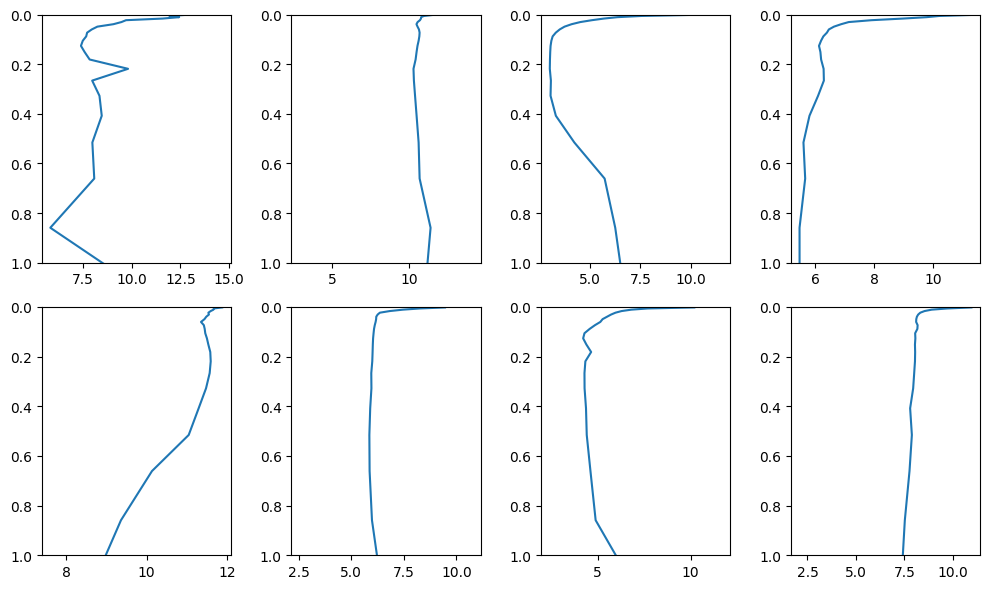

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))
for e, eddy in enumerate(sample_eddies):

    df_eddy = out.filter(like=f"Eddy{eddy}").copy()

    ax = axs[e // 4, e % 4]
    
    ax.plot(df_eddy.mean(axis=1), out.Depth/1e3)
    ax.invert_yaxis(); ax.set_ylim(1, 0)
plt.tight_layout()


### Extract TD

In [12]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        if len(df):
            df2 = df.copy()
            cols = df2.columns.drop("Depth")
            df2[cols] = df2[cols].sub(df2[cols].iloc[0])
    
            tmp = (df2[['x','y']] if not df2.empty else pd.DataFrame(index=[], columns=['x','y']))
            tmp = tmp.reindex(range(n))                     # pads with NaNs
            tmp.columns = [f'{eddy}_x_{d}', f'{eddy}_y_{d}']
            frames.append(tmp)

df_depths = pd.concat([base, *frames], axis=1, copy=False)
df_depths


Depth Eddy66_x_0 Eddy66_y_0 Eddy66_x_1 Eddy66_y_1 Eddy66_x_2  \
0      1.783320        0.0        0.0        0.0        0.0        0.0   
1      5.879627    0.36608  -0.469797   0.604297  -0.083208   0.845479   
2     10.725783   0.407074  -0.658693   1.008869   0.063761    1.21786   
3     16.383097    0.56092  -0.413251   1.402169   0.301284   1.476608   
4     22.925581   0.675685  -0.834556   1.636942   0.176231   1.699155   
5     30.444118   0.816247  -0.654199   2.029575   0.611816   2.547861   
6     39.052712   1.034239  -0.827745   2.408733   1.246443    2.61189   
7     48.897638    1.39736  -0.885034   2.436052   2.734058   2.688233   
8     60.170639   1.954069  -0.630895   2.922325   4.098163   2.753345   
9     73.127842   3.218907   0.270195   3.720559   6.133528    2.42103   
10    88.116838   5.068008   2.271339   5.423352  10.304244   1.383731   
11   105.615538   5.870513    6.63895   4.235113   13.67959  -1.285185   
12   126.288127   6.237491  11.417201   2.884126  18.437098  -3.032171   
13   151.065954    4.82335  15.038125  -0.485298  25.806531   -4.34754   
14   181.264793   0.961884   25.55881  -0.304855  27.204444  -4.839212   
15   218.754856   0.945492  43.136635  -1.704161  29.046105  -6.298578   
16   266.206398  -1.852357  46.161051 -11.049078  39.704692 -10.973806   
17   327.440851  -3.163521  66.825028  -8.074717   37.03477 -10.449143   
18   407.922192  -1.940309  54.485123  -9.670477  38.387906 -12.931918   
19   515.416489        NaN        NaN -14.151857  39.240378 -17.591714   
20   660.806374        NaN        NaN  -19.78104  41.497942 -23.226462   
21   858.918478        NaN        NaN -31.562863   89.87711        NaN   
22  1128.898331        NaN        NaN        NaN        NaN        NaN   
23  1492.971178        NaN        NaN        NaN        NaN        NaN   
24  1971.212518        NaN        NaN        NaN        NaN        NaN   
25  2568.677466        NaN        NaN        NaN        NaN        NaN   
26  3252.716389        NaN        NaN        NaN        NaN        NaN   
27  3930.053268        NaN        NaN        NaN        NaN        NaN   
28  4460.447022        NaN        NaN        NaN        NaN        NaN   
29  4748.917670        NaN        NaN        NaN        NaN        NaN   

   Eddy66_y_2 Eddy66_x_5  Eddy66_y_5 Eddy66_x_6  ... Eddy2128_x_52  \
0         0.0        0.0         0.0        0.0  ...           0.0   
1    0.269648  -0.092296   -0.550589   0.497388  ...     -5.474863   
2    0.475892  -0.083245   -0.837792   0.828936  ...     -6.802928   
3    0.706821  -0.085089   -1.079316   1.039673  ...     -9.284528   
4    0.977804  -0.084873   -1.409012   1.324819  ...     -9.173816   
5    3.347905  -0.135368   -1.641309   1.386752  ...     -9.314653   
6    4.982241  -0.224089   -1.830617   1.546909  ...     -9.413788   
7    5.726514  -0.443279   -1.973692   2.004685  ...     -9.465317   
8    8.146996  -0.871459   -2.246697   1.619441  ...     -9.549117   
9   12.178853  -2.144115   -3.429023   2.766193  ...     -9.655466   
10   18.80706  -1.258085   -5.705204   2.633008  ...     -9.747127   
11  24.044676  -0.836541   -9.030227   1.931558  ...     -9.765817   
12  24.027129  -0.928793  -11.019907   7.158402  ...     -9.508848   
13  26.247456  -1.472919  -13.006238   7.784555  ...     -8.667713   
14  26.857758  -2.100394  -14.155453   7.240863  ...     -8.395517   
15  27.565879    -2.9857  -15.592196   5.422638  ...     -8.560935   
16  28.957071  -3.400587  -16.293397   3.624232  ...     -8.458504   
17  29.125157  -4.234869  -15.970993   3.267139  ...     -8.604947   
18  26.498088  -5.646515  -29.444128   4.746146  ...     -8.148812   
19  24.218958  -7.496242  -46.606715   0.459303  ...     -7.869544   
20  24.652724 -10.308123  -51.830651  -0.843309  ...     -8.265906   
21        NaN -13.090722  -69.300524  -6.741502  ...      -7.79095   
22        NaN -30.245589 -102.423772 -15.944417  ...     -5.145027   
23        NaN        NaN         Na

In [13]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        tmp = (df[['TD']] if not df.empty else pd.DataFrame(index=[], columns=['TD']))
        tmp = tmp.reindex(range(n))                     # pads with NaNs
        tmp.columns = [f'{eddy}_{d}']
        frames.append(tmp)
df_depths_TD = pd.concat([base, *frames], axis=1, copy=False)
df_depths_TD


Depth   Eddy66_0   Eddy66_1   Eddy66_2 Eddy66_3 Eddy66_4  \
0      1.783320   0.000000   0.000000   0.000000      NaN      NaN   
1      5.879627   0.595587   0.609998   0.887437      NaN      NaN   
2     10.725783   0.774329   1.010881   1.307538      NaN      NaN   
3     16.383097   0.696712   1.434172   1.637061      NaN      NaN   
4     22.925581   1.073794   1.646401   1.960415      NaN      NaN   
5     30.444118   1.046057   2.119786   4.207145      NaN      NaN   
6     39.052712   1.324693   2.712124   5.625362      NaN      NaN   
7     48.897638   1.654056   3.661888   6.326102      NaN      NaN   
8     60.170639   2.053390   5.033381   8.599678      NaN      NaN   
9     73.127842   3.230227   7.173752  12.417160      NaN      NaN   
10    88.116838   5.553709  11.644320  18.857896      NaN      NaN   
11   105.615538   8.862200  14.320174  24.078998      NaN      NaN   
12   126.288127  13.009949  18.661317  24.217700      NaN      NaN   
13   151.065954  15.792717  25.811094  26.605075      NaN      NaN   
14   181.264793  25.576904  27.206152  27.290239      NaN      NaN   
15   218.754856  43.146995  29.096054  28.276311      NaN      NaN   
16   266.206398  46.198202  41.213404  30.966698      NaN      NaN   
17   327.440851  66.899868  37.904819  30.942840      NaN      NaN   
18   407.922192  54.519661  39.587239  29.485304      NaN      NaN   
19   515.416489        NaN  41.714294  29.933699      NaN      NaN   
20   660.806374        NaN  45.971391  33.870715      NaN      NaN   
21   858.918478        NaN  95.258119        NaN      NaN      NaN   
22  1128.898331        NaN        NaN        NaN      NaN      NaN   
23  1492.971178        NaN        NaN        NaN      NaN      NaN   
24  1971.212518        NaN        NaN        NaN      NaN      NaN   
25  2568.677466        NaN        NaN        NaN      NaN      NaN   
26  3252.716389        NaN        NaN        NaN      NaN      NaN   
27  3930.053268        NaN        NaN        NaN      NaN      NaN   
28  4460.447022        NaN        NaN        NaN      NaN      NaN   
29  4748.917670        NaN        NaN        NaN      NaN      NaN   

      Eddy66_5   Eddy66_6   Eddy66_7   Eddy66_8  ...  Eddy2128_47  \
0     0.000000   0.000000   0.000000   0.000000  ...     0.000000   
1     0.558271   1.923610   2.525449   0.813649  ...     1.705146   
2     0.841918   2.962373   4.305580   1.171885  ...     2.579791   
3     1.082665   3.739314   4.602314   1.404957  ...     3.244232   
4     1.411566   4.561419   5.119526   1.907882  ...     3.807857   
5     1.646882   4.345403   5.968408   2.074614  ...     4.297784   
6     1.844281   4.980971   6.326690   2.217266  ...     4.394558   
7     2.022858   6.653524   6.020544   2.166461  ...     4.379046   
8     2.409790   6.880386   6.917752   2.289005  ...     4.399852   
9     4.044185   8.739984   6.560825   2.426779  ...     4.418925   
10    5.842271   9.413045   7.314174   2.547908  ...     4.390040   
11    9.068891   9.553742   7.812040   2.837081  ...     4.443143   
12   11.058978  18.722530   8.191352   3.563464  ...     4.420177   
13   13.089374  17.858884  11.207434   5.017404  ...     4.139266   
14   14.310433  20.559286  12.733958   5.270281  ...     4.697358   
15   15.875484  21.569183  13.203807   8.932758  ...     4.970712   
16   16.644482  22.827010  16.240418  17.808632  ...     4.542351   
17   16.522915  25.107525  18.456730  30.373022  ...     4.603330   
18   29.980657  49.733209  40.032228  54.046300  ...     4.917819   
19   47.205715  60.705580  56.000024  59.555708  ...     5.195689   
20   52.845755  68.904944  58.443946  62.434829  ...     5.426877   
21   70.526092  76.104809  66.382693  66.617610  ...     7.137501   
22  106.796184  85.514453  83.117180  83.663266  ...    10.528583   
23         NaN  71.951253  82.046128        NaN  ...    15.674690   
24         NaN        NaN        NaN        NaN  ...    33.232600   
25         NaN        NaN        NaN        N

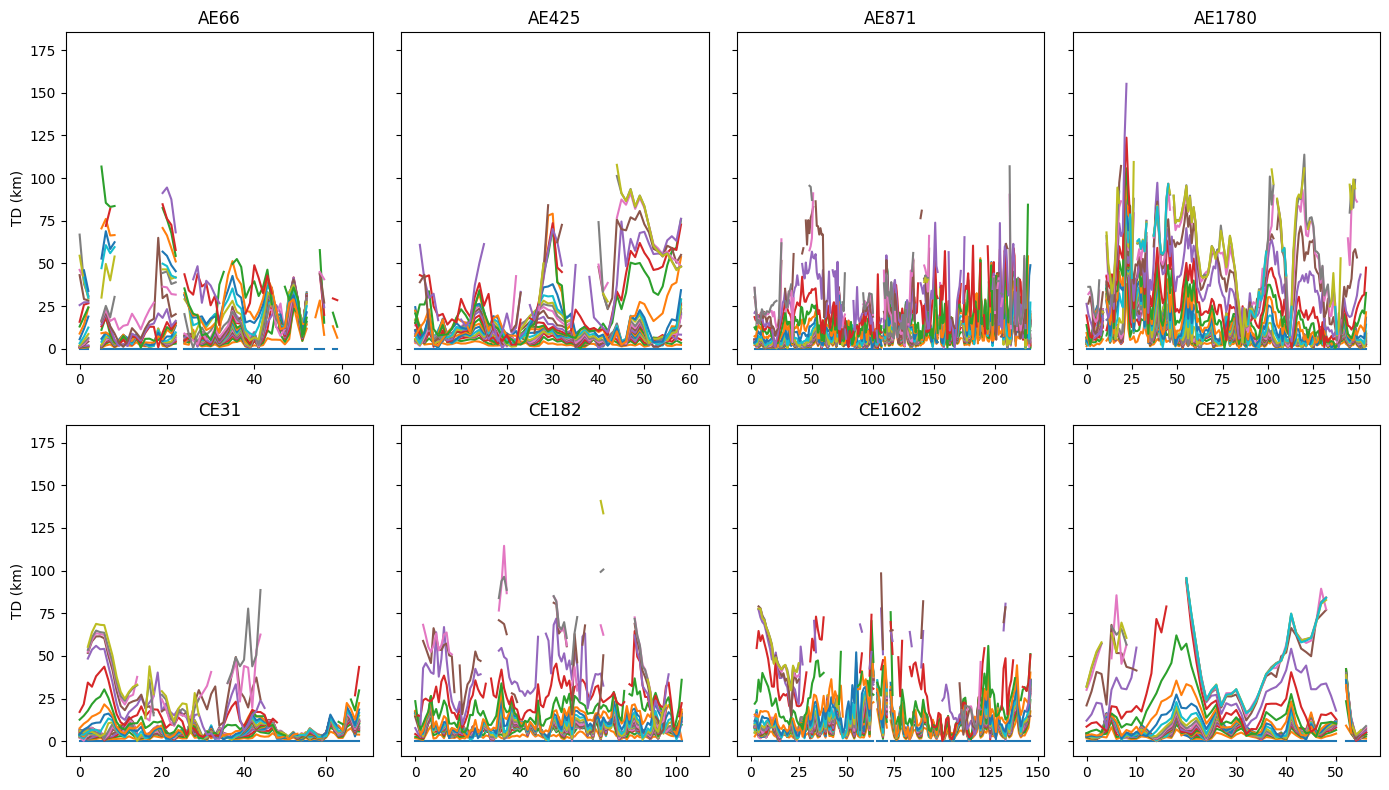

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
# lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    # df_sub = df.loc[:, df.columns.str.contains(f"Eddy{eddy}") | (df.columns == "Depth")]
    df_sub = df_depths_TD.loc[:, df_depths_TD.columns.str.contains(f'Eddy{eddy}')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
axs[0,0].set_ylabel('TD (km)')
axs[1,0].set_ylabel('TD (km)')
# axs[0,1].legend(ncol=2)
plt.tight_layout()


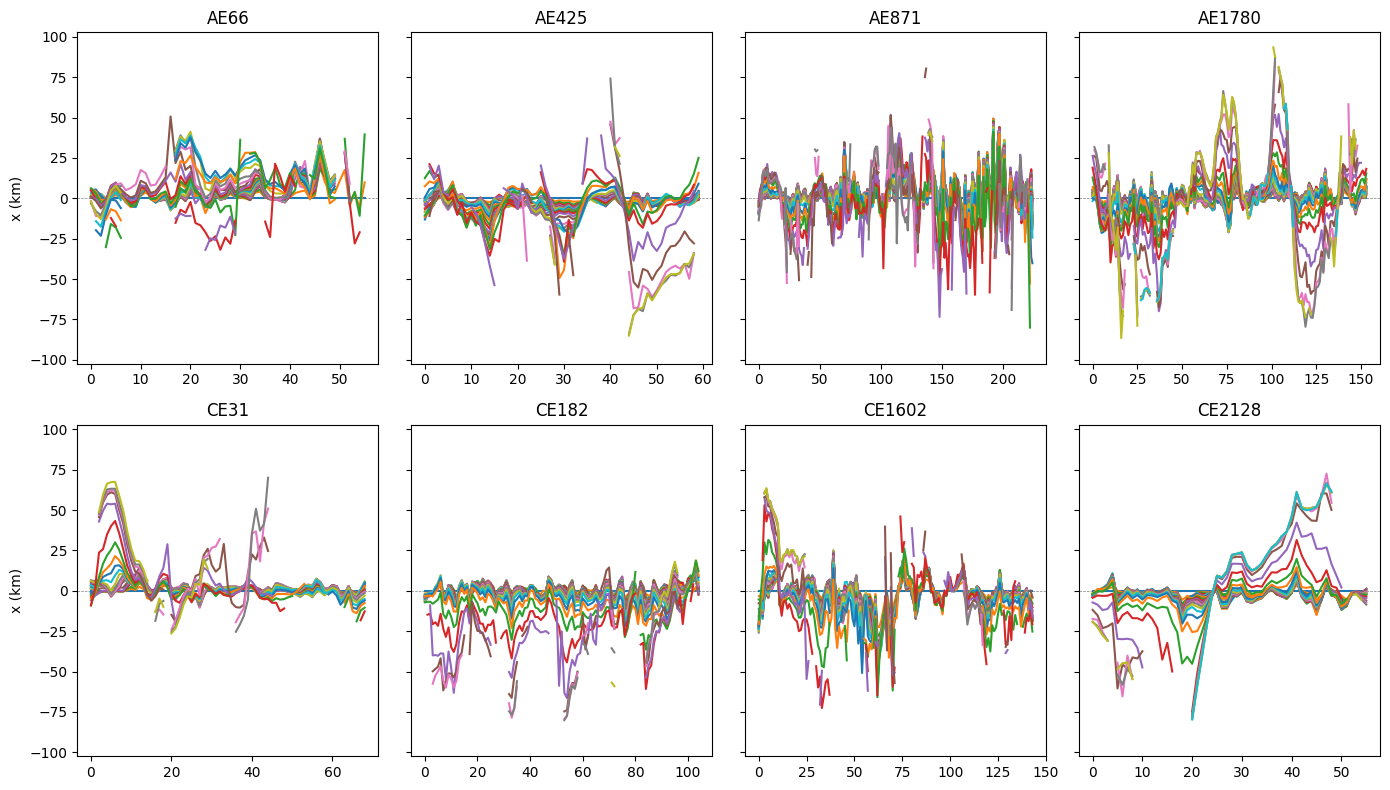

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
# lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    ax.axhline(y=0, lw=.5, ls='--', color='k', alpha=.5)
    df_sub = df_depths.loc[:, df_depths.columns.str.contains(f'Eddy{eddy}_x')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
axs[0,0].set_ylabel('x (km)')
axs[1,0].set_ylabel('x (km)')
# axs[0,1].legend(ncol=2)
plt.tight_layout()

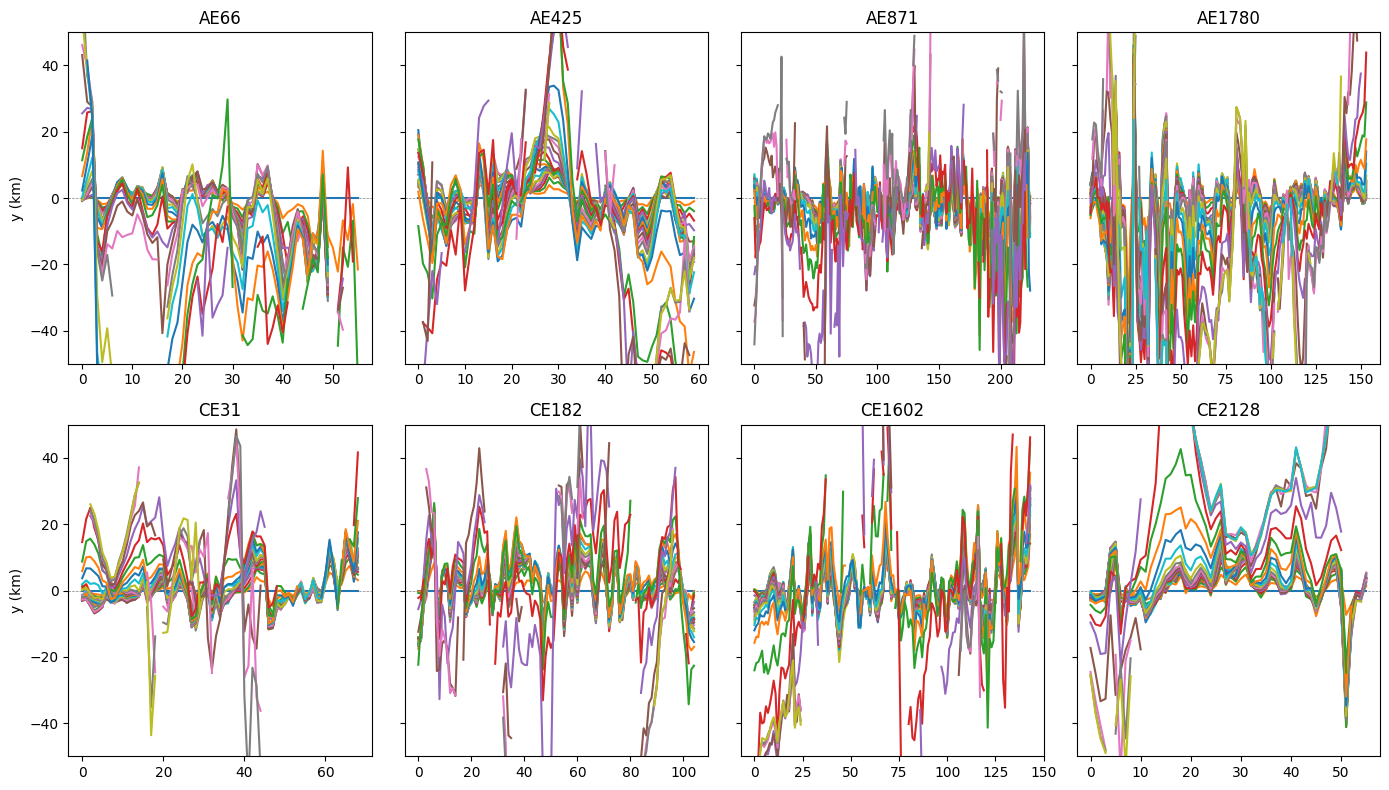

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    ax.axhline(y=0, lw=.5, ls='--', color='k', alpha=.5)
    df_sub = df_depths.loc[:, df_depths.columns.str.contains(f'Eddy{eddy}_y')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    
axs[0,0].set_ylabel('y (km)')
axs[1,0].set_ylabel('y (km)')
axs[0,0].set_ylim(-50, 50)
# axs[0,1].legend(ncol=2)
plt.tight_layout()


### Li Tilt

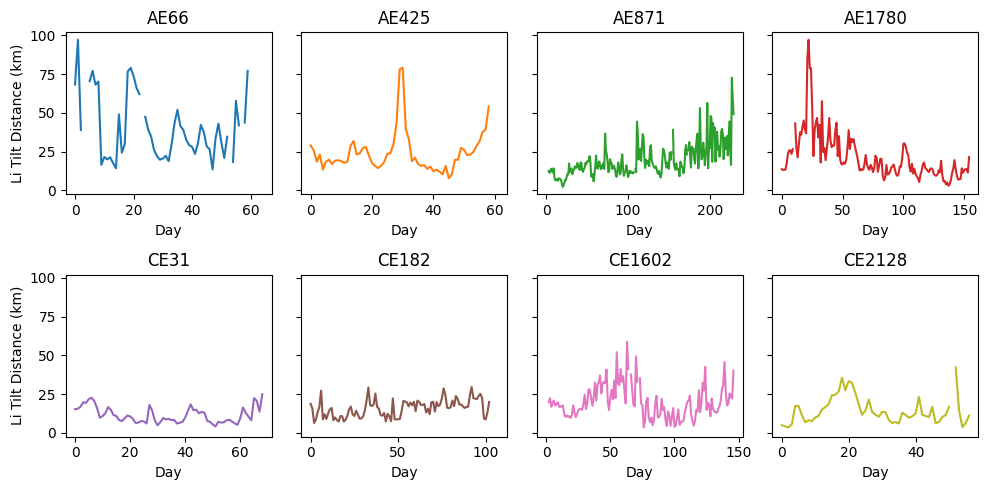

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    days = sorted(dic.keys())
    TDis = []
    for day in days:
        df = dic[day].copy()
        if len(df):
            df = df[df.Depth.abs() < 1000]
            td, th, _ = tilt_distance_LI(df.x.values, df.y.values, -df.Depth.values)
            TDis.append(td)
        else:
            TDis.append(np.nan)
    ax.plot(range(len(TDis)), TDis, color=colors[e % 10])
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Li Tilt Distance (km)')
axs[1,0].set_ylabel('Li Tilt Distance (km)')
plt.tight_layout()


### Regs Tilt

In [18]:
# for e, eddy in enumerate(sample_eddies):
#     dic = dic_sample[f'Eddy{eddy}']
#     df = compute_tilt_data(dic, eddy)
#     if e == 0:
#         df_tilt_data = df
#     else:
#         df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
# df_eddies = df_eddies.merge(
#     df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
#     how='left',
#     left_on=['Eddy', 'Day'],
#     right_on=['Eddy', 'Day']
# )

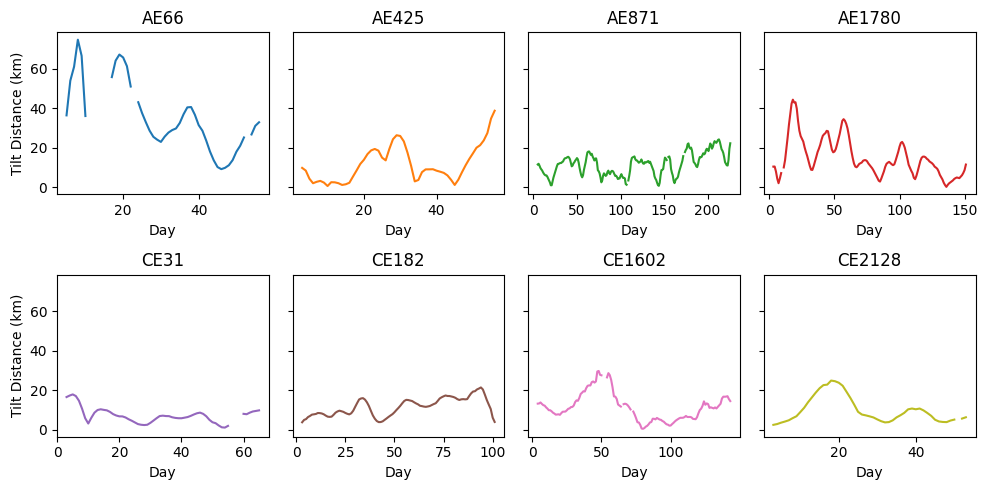

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(np.arange(len(df)), df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Tilt Distance (km)')
axs[1,0].set_ylabel('Tilt Distance (km)')
plt.tight_layout()


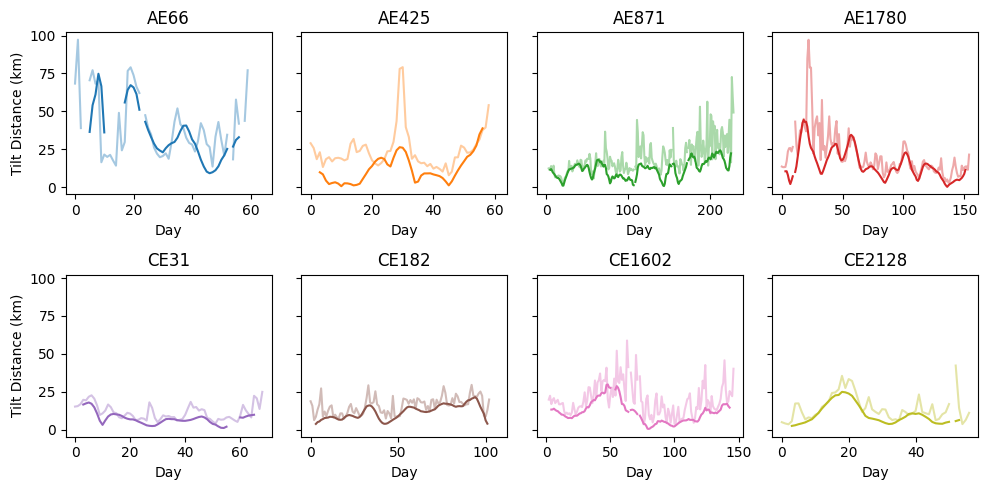

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    days = sorted(dic.keys())
    TDis = []
    for day in days:
        df = dic[day].copy()
        if len(df):
            df = df[df.Depth.abs() < 1000]
            td, th, _ = tilt_distance_LI(df.x.values, df.y.values, -df.Depth.values)
            TDis.append(td)
        else:
            TDis.append(np.nan)
    ax.plot(range(len(TDis)), TDis, color=colors[e % 10], alpha=.4)
    df = df_eddies[df_eddies.Eddy==int(eddy[4:])]
    ax.plot(np.arange(len(df)), df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')
    ax.set_xlabel('Day')
    # ax.axhline(y=10, color='r')
axs[0,0].set_ylabel('Tilt Distance (km)')
axs[1,0].set_ylabel('Tilt Distance (km)')

plt.tight_layout()


#### My Tilt Breakdown

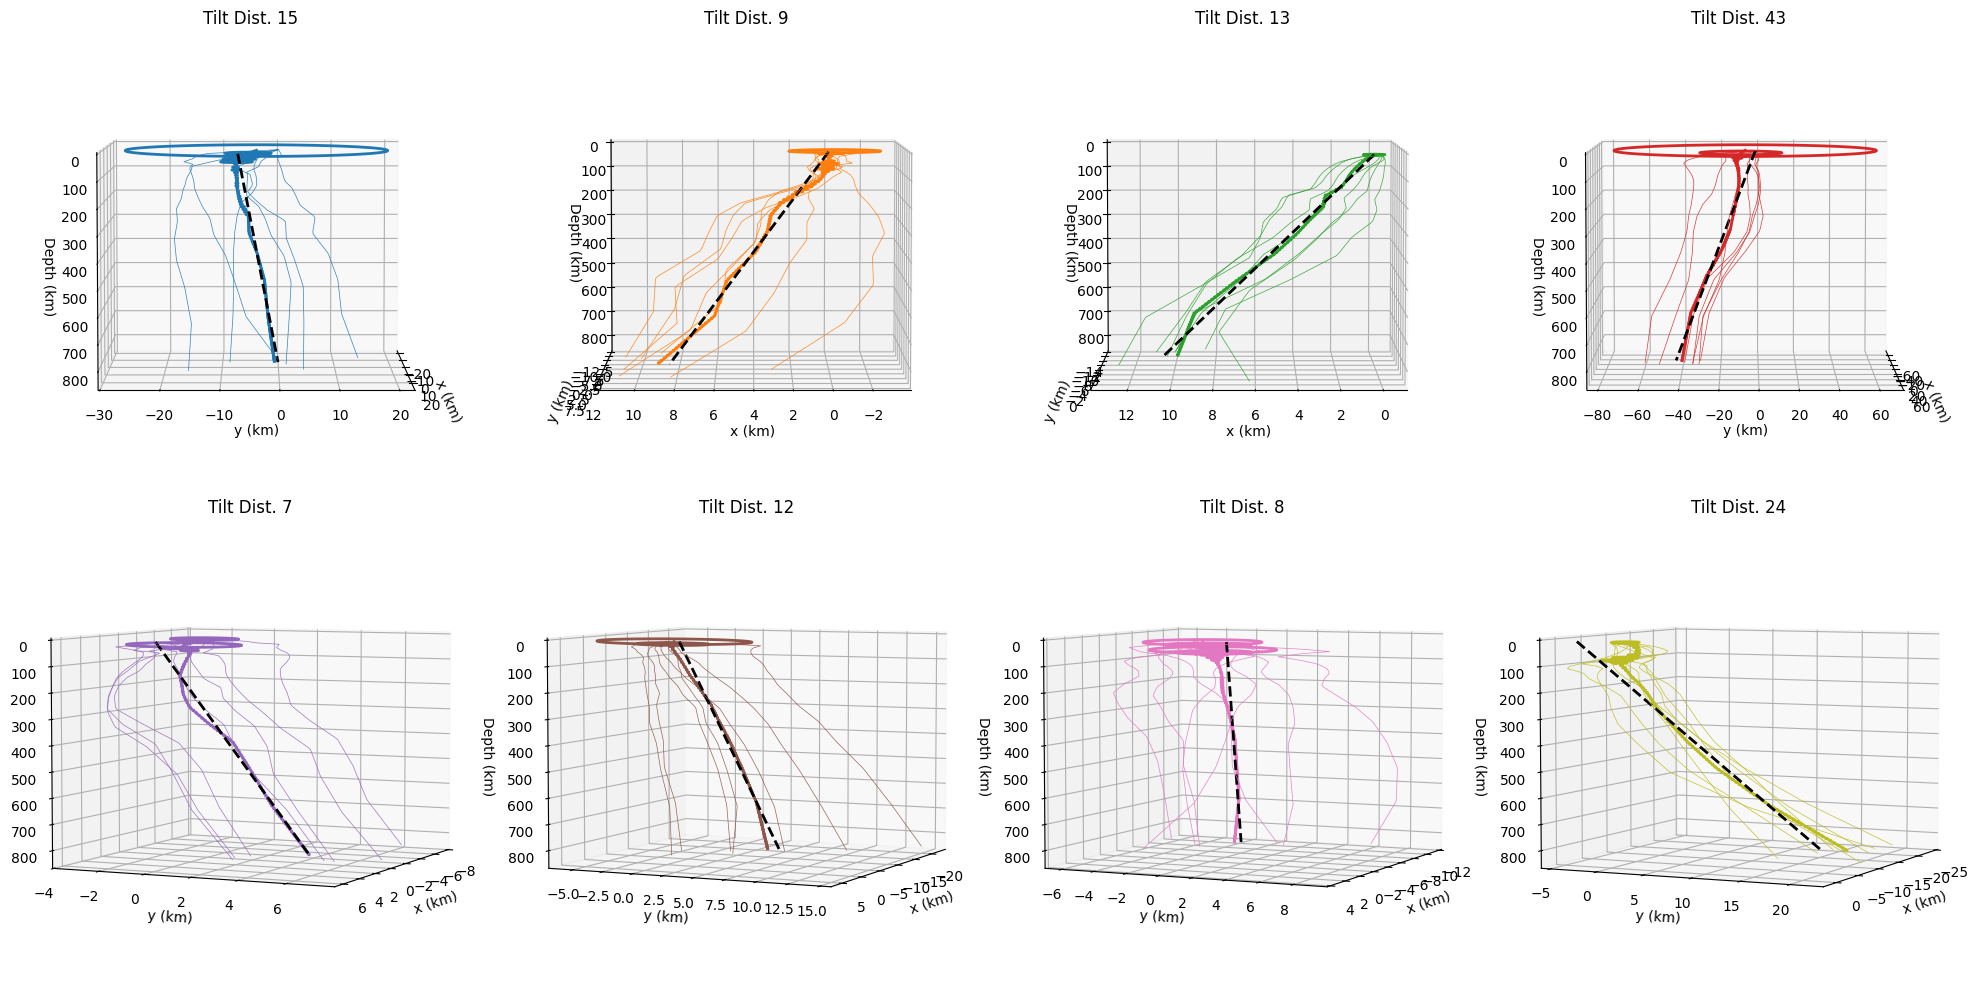

In [21]:
from mpl_toolkits.mplot3d import Axes3D 

# Create a 2x4 grid of 3D subplots
fig = plt.figure(figsize=(20, 10))  # make it wide and tall enough
axes = []

ref_days = [50, 40, 52, 20, 
            20, 30, 20, 20]
azims = [0, 90, 90, 0,
         25, 25, 25, 25]

for e, (eddy, ref_day) in enumerate(zip(sample_eddies, ref_days)):
    dic = dic_sample[f'Eddy{eddy}']
    num = 6
    depth_int = 10
    max_depth = 1000
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
    df_x_interp = {}
    df_y_interp = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        if len(df):
            depths = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
            y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        else:
            idx = [depth_int]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    df_x_interp_all = pd.DataFrame(df_x_interp)
    df_y_interp_all = pd.DataFrame(df_y_interp)
    
    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}

        ax = fig.add_subplot(2, 4, e+1, projection='3d')
        axes.append(ax)

        y = df_x_interp.index.to_numpy()
        
        for t in range(df_x_interp.shape[1]):
            xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
            yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
            ax.plot(xt, yt, y, alpha=.9, lw=.5, color=colors[e])
            if t == 3:
                xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
                ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
                d   = df_data['Depth'].to_numpy()
                tvar = df_data[r'Total $\sigma^2$'].to_numpy()
        
                ax.plot(xmu, ymu, d, color=colors[e], lw=2)
        
                theta = np.linspace(0, 2*np.pi, 100)
                for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
                    cx = xm + rv*np.cos(theta)
                    cy = ym + rv*np.sin(theta)
                    cz = np.full_like(cx, dm)
                    ax.plot(cx, cy, cz, lw=2, color=colors[e])
        
                ax.plot([top[0], btm[0]], [top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)
        
        ax.invert_zaxis()
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_zlabel('Depth (km)')
        
        ax.view_init(elev=5, azim=azims[e])
        ax.set_title(f'Tilt Dist. {round(tilt_dist)}')
    
plt.tight_layout()
plt.show()


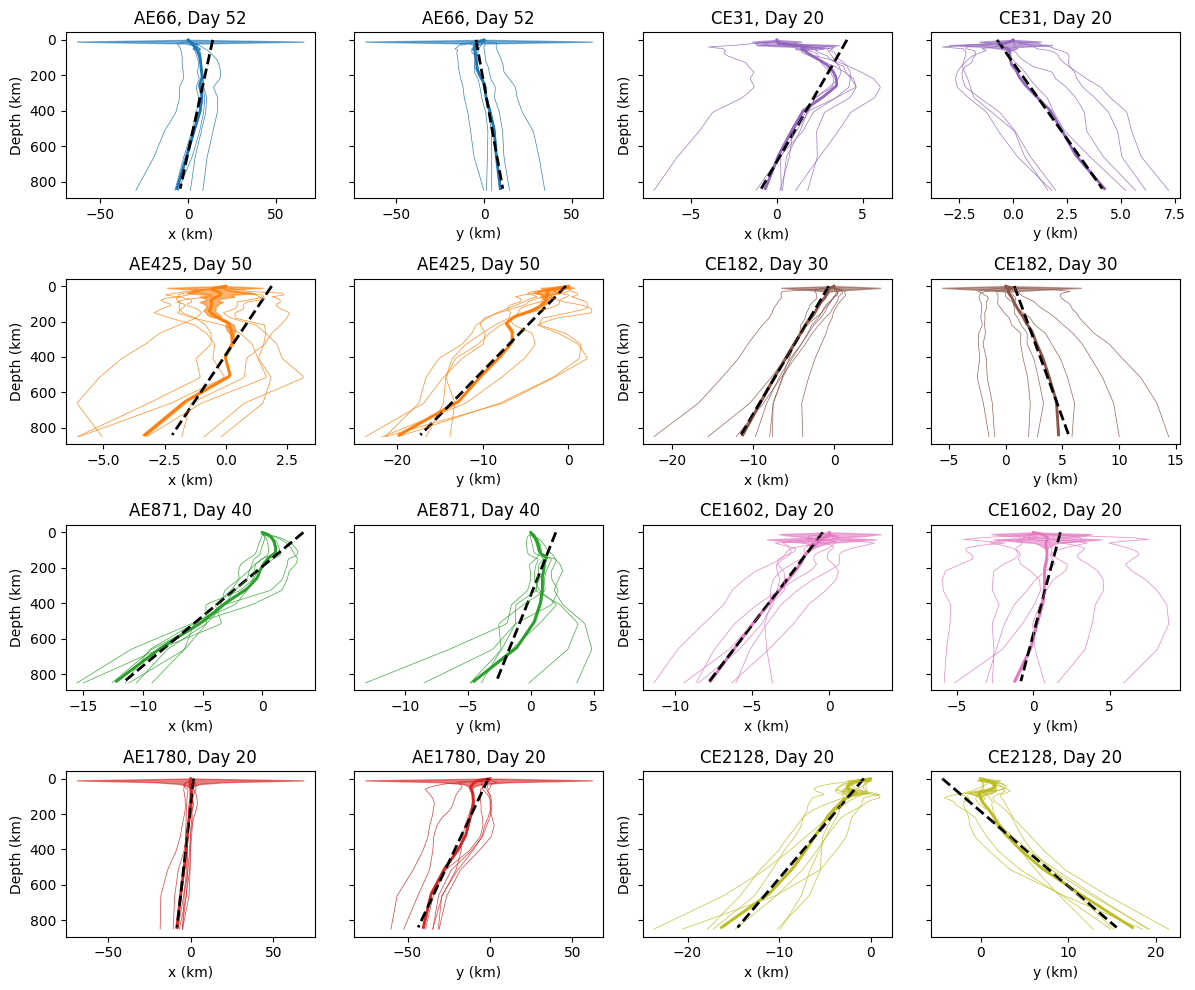

In [22]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)

ref_days = [52, 50, 40, 20, 
            20, 30, 20, 20]
for e, (eddy, ref_day) in enumerate(zip(sample_eddies, ref_days)):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    
    dic = dic_sample[f'Eddy{eddy}']
    num = num
    depth_int = 10
    max_depth = 1000
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
    df_x_interp = {}
    df_y_interp = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        if len(df):
            depths = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
            y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        else:
            idx = [depth_int]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    df_x_interp_all = pd.DataFrame(df_x_interp)
    df_y_interp_all = pd.DataFrame(df_y_interp)
    
    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data = pd.concat([pd.DataFrame([0]*len(df_data.columns), index=df_data.columns).T, df_data], ignore_index=True)
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}

        # PLOT

        y = df_x_interp.index.to_numpy()
        
        for t in range(df_x_interp.shape[1]):
            xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
            yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
            
            ax0.plot(xt, y, alpha=.9, lw=.5, color=colors[e])
            ax1.plot(yt, y, alpha=.9, lw=.5, color=colors[e])

            if t == 3:
                xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
                ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
                d   = df_data['Depth'].to_numpy()
                tvar = df_data[r'Total $\sigma^2$'].to_numpy()
        
                theta = np.linspace(0, 2*np.pi, 100)
                cx_mins, cx_maxs, cy_mins, cy_maxs = [], [], [], []
                for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
                    cx = xm + rv*np.cos(theta)
                    cy = ym + rv*np.sin(theta)
                    cz = np.full_like(cx, dm)

                    cx_mins.append(cx.min())
                    cx_maxs.append(cx.max())
                    cy_mins.append(cy.min())
                    cy_maxs.append(cy.max())
                    
                    # ax0.plot(cx, cz, lw=2, color=colors[e])
                    # ax1.plot(cy, cz, lw=2, color=colors[e])
                ax0.fill_betweenx(d, cx_mins, cx_maxs, color=colors[e], alpha=0.6)
                ax1.fill_betweenx(d, cy_mins, cy_maxs, color=colors[e], alpha=0.6)

                ax0.plot(xmu, d, color=colors[e], lw=2)
                ax1.plot(ymu, d, color=colors[e], lw=2)

                ax0.plot([top[0], btm[0]], [top[2], btm[2]], color='k', ls='--', lw=2)
                ax1.plot([top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)

        ax0.set_xlabel('x (km)')
        ax1.set_xlabel('y (km)')
        ax0.set_ylabel('Depth (km)')

        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
        ax0.set_title(f'{cyc}{eddy}, Day {ref_day}')
        ax1.set_title(f'{cyc}{eddy}, Day {ref_day}')

        # ax0.set_xlim(-50, 50)
        # ax1.set_xlim(-50, 50)

axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

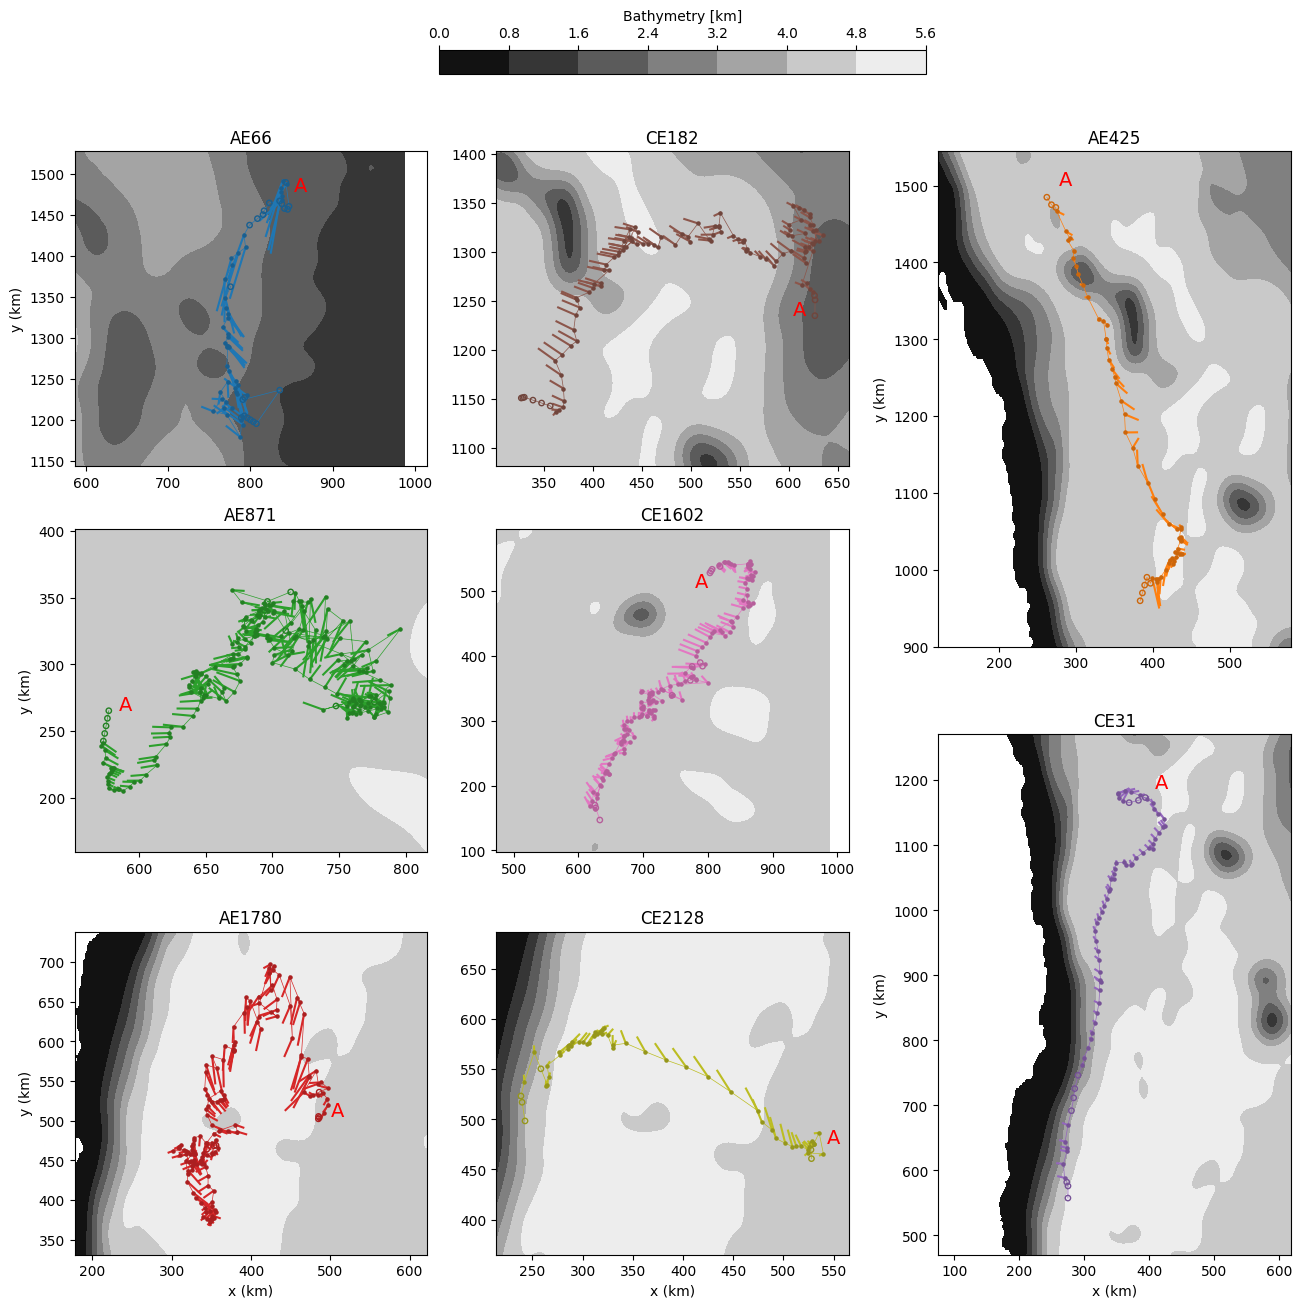

In [25]:
def point_b(a, r, theta_deg):
    theta_rad = np.radians(theta_deg)
    dx = r * np.sin(theta_rad)
    dy = r * np.cos(theta_rad)
    return a[0] - dx, a[1] - dy

from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)

fig = plt.figure(figsize=(13, 13), constrained_layout=True)
gs = fig.add_gridspec(6, 3)

gap = 5
mappable = None
s = 5

# slots for all non-special eddies on a 6x3 grid (left two columns)
# roughly mimics a 3x2 layout: rows 0,2,4
normal_slots = [
    (0, 0), (2, 0), (4, 0),
    (0, 1), (2, 1), (4, 1),
]

k = 0
axes_list = []
for e, eddy in enumerate(sample_eddies):

    # eddy 1 and 4 get tall panels in the right column
    if e == 1:
        ax = fig.add_subplot(gs[0:3, 2])   # top-right, 1.5 "rows" tall
        axes_list.append(ax)
        col = 2
        row = 0
        is_tall = True
        ax.set_ylabel('y (km)')
    elif e == 4:
        ax = fig.add_subplot(gs[3:6, 2])   # bottom-right, 1.5 "rows" tall
        axes_list.append(ax)
        col = 2
        row = 4
        is_tall = True
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
    else:
        row, col = normal_slots[k]
        k += 1
        ax = fig.add_subplot(gs[row:row+2, col])
        axes_list.append(ax)
        is_tall = False

    df = df_eddies[df_eddies.Eddy == eddy]
    m = ax.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='gray')
    if mappable is None:
        mappable = m

    df_eddy = df_eddies[df_eddies.Eddy == eddy]
    ax.plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, zorder=1)

    for d, day in enumerate(df['Day'].unique()):
        data = df[df.Day == day]
        tilt_dis = data.iloc[0].TiltDis
        tilt_dir = data.iloc[0].TiltDir

        plot_data = df_eddies[(df_eddies.Eddy == eddy) & (df_eddies['Day'] == int(day))]
        x0, y0 = plot_data.iloc[0].xc, plot_data.iloc[0].yc
        xb, yb = point_b([x0, y0], tilt_dis, (tilt_dir - 20) % 360)

        ax.plot([x0, xb], [y0, yb], color=colors[e], zorder=2)

        cyc = df_eddies[df_eddies.Eddy == eddy].Cyc.iloc[0]
        if d == 0:
            ax.plot([x0, xb], [y0, yb], color=colors[e], zorder=2,
                    label=f'{cyc}{eddy}')

        if np.isnan(tilt_dis):
            ax.scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                       s=15, zorder=3, facecolors='none')
        else:
            ax.scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                       s=s, zorder=3)
    if eddy==1602:
        a, b = -1.5, -1.5
    elif eddy==1780:
        a, b = 1, 0
    elif eddy==182:
        a, b = -1.5, 0
    elif eddy==871:
        a, b = .5, 0
    else:
        a, b = 1, 1
        
    ax.text(df_eddy.iloc[0].xc+a*15, df_eddy.iloc[0].yc+b*15, 'A',
            color='r', fontsize=14)
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.axis('equal'); ax.set_title(f'{cyc}{eddy}')
    ax.set_xlim(df_eddy.xc.min() - gap, df_eddy.xc.max() + gap)
    ax.set_ylim(df_eddy.yc.min() - gap, df_eddy.yc.max() + gap)

    # axis labels: left column gets y, bottom band gets x
    if col == 0:
        ax.set_ylabel('y (km)')
    # bottom "row" for small plots (row==4) and the lower tall panel (eddy 4)
    if (not is_tall and row == 4) or (is_tall and e == 4):
        ax.set_xlabel('x (km)')

cbar = fig.colorbar(mappable, ax=axes_list, location='top', shrink=0.4)
cbar.set_label('Bathymetry [km]')



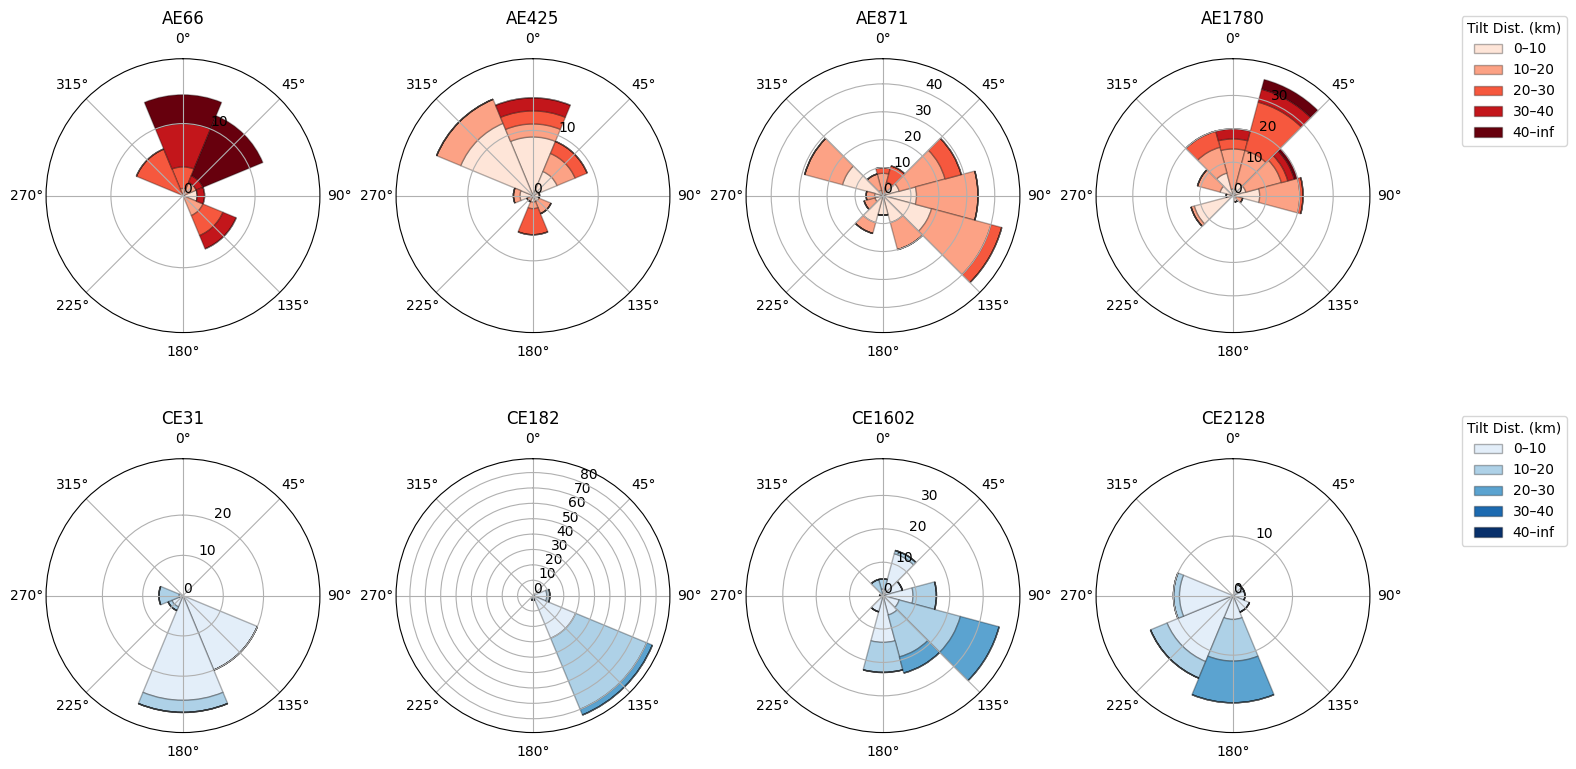

In [26]:
def choose_dir_bins_cardinal(*dfs, col='TiltDir', min_bins=8, max_bins=36, min_avg_per_sector=8):
    candidates = np.array([4, 6, 8, 9, 10, 12, 15, 16, 18, 20, 24, 30, 36, 45, 60, 72])
    candidates = candidates[(candidates >= min_bins) & (candidates <= max_bins)]
    candidates = candidates[candidates % 4 == 0]

    Ns = []
    for df in dfs:
        x = df[col].to_numpy()
        x = x[np.isfinite(x)]
        Ns.append(x.size)
    N = min(Ns) if Ns else 0

    if N == 0 or candidates.size == 0:
        k = 16
    else:
        k0 = int(np.ceil(2 * N ** (1/3)))
        k = candidates[np.argmin(np.abs(candidates - k0))]
        while k > candidates.min() and (N / k) < min_avg_per_sector:
            k = candidates[candidates < k].max()

    dir_bins = np.linspace(0.0, 360.0, k + 1)
    shift = 180.0 / k
    return dir_bins, shift

# ---- per-eddy windroses (bins chosen per panel) ----
fig, axs = plt.subplots(
    2, 4, figsize=(14, 8),
    subplot_kw={'projection': 'polar'},
    constrained_layout=True
)
axs = axs.flatten()

sample_eddies_8 = sample_eddies[:8]
mag_bins = [0, 10, 20, 30, 40, np.inf]

colors_AE = plt.cm.Reds(np.linspace(0.1, 1, len(mag_bins) - 1))
colors_CE = plt.cm.Blues(np.linspace(0.1, 1, len(mag_bins) - 1))

for ax, eddy in zip(axs, sample_eddies_8):
    df = df_eddies[df_eddies.Eddy == eddy].copy()

    directions = np.mod(df.TiltDir.to_numpy(), 360.0)
    magnitudes = df.TiltDis.to_numpy()
    m = np.isfinite(directions) & np.isfinite(magnitudes)
    directions = directions[m]
    magnitudes = magnitudes[m]

    cyc = df.iloc[0].Cyc if len(df) else ""
    colorss = colors_AE if cyc == "AE" else colors_CE

    # --- choose direction bins for THIS eddy only ---
    dir_bins, dir_shift = choose_dir_bins_cardinal(df, col='TiltDir', min_bins=8, max_bins=36, min_avg_per_sector=6)
    k = len(dir_bins) - 1
    binw_deg = 360.0 / k
    angles = np.deg2rad(np.arange(k) * binw_deg)
    width = np.deg2rad(binw_deg)

    directions_s = np.mod(directions + dir_shift, 360.0)
    dir_idx = np.digitize(directions_s, dir_bins, right=False) - 1
    mag_idx = np.digitize(magnitudes, mag_bins, right=False) - 1

    counts = np.zeros((len(mag_bins) - 1, k))
    for d_i, m_i in zip(dir_idx, mag_idx):
        if 0 <= d_i < k and 0 <= m_i < (len(mag_bins) - 1):
            counts[m_i, d_i] += 1

    bottom = np.zeros(k)
    for i in range(counts.shape[0]):
        ax.bar(
            angles, counts[i], width,
            bottom=bottom,
            color=colorss[i],
            edgecolor=(0, 0, 0, 0.3),
            label=f'{mag_bins[i]:g}–{mag_bins[i+1]:g}'
        )
        bottom += counts[i]
    rmax = bottom.max()
    ax.set_rlim(0, rmax + 5)
    ax.set_rticks(np.arange(0, rmax + 1, 10))
    ax.set_title(f'{cyc}{eddy}')# (k={k})')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 0.98), title='Tilt Dist. (km)')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 0.48), title='Tilt Dist. (km)')

plt.show()



/scratch/pbs.7500951.kman.restech.unsw.edu.au/ipykernel_2589794/2760536021.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=labels, showfliers=True, patch_artist=True,)


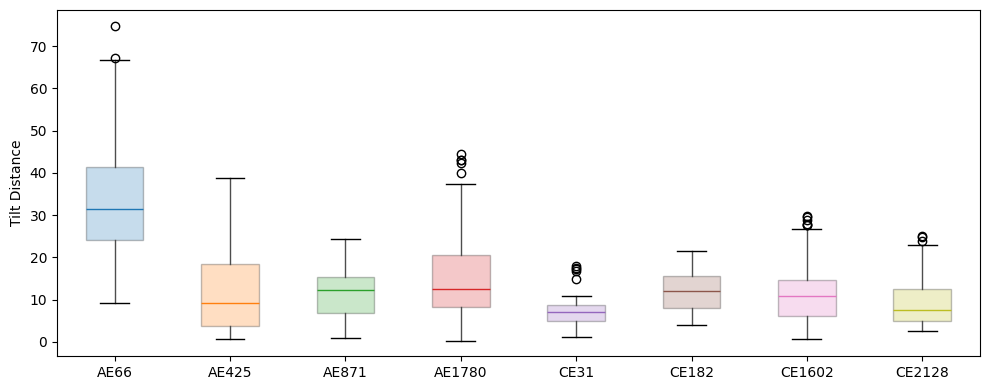

In [32]:
fig, ax = plt.subplots(figsize=(10, 4))

data = []
labels = []

for eddy in sample_eddies:
    x = df_eddies.loc[df_eddies.Eddy == eddy, 'TiltDis'].to_numpy()
    x = x[np.isfinite(x)]
    data.append(x)
    cyc = df_eddies.loc[df_eddies.Eddy == eddy].iloc[0].Cyc
    labels.append(f'{cyc}{eddy}')

bp = ax.boxplot(data, labels=labels, showfliers=True, patch_artist=True,)

for i, (box, med) in enumerate(zip(bp['boxes'], bp['medians'])):
    box.set_facecolor(colors[i])
    box.set_alpha(0.25)
    med.set_color(colors[i])

for whisker in bp['whiskers']:
    whisker.set_color('0.3')
ax.set_ylabel('Tilt Distance')

plt.tight_layout()
plt.show()


In [ ]:
# Adjustable bin width
bin_width = 10  # km
max_depth_km = 40  # adjust as needed

# bins = np.arange(0, max_depth_km + bin_width, bin_width)
bins = [ 0, 10, 20, 30, np.inf]
bin_labels = [f"[{b}–{b+bin_width})" for b in bins[:-2]] \
           + [f"[{bins[-2]}–{bins[-1]}]"]

# Prepare DataFrame
eddies = [int(eddy[4:]) for eddy in list(dic_sample.keys())]
cycs = [df_eddies[df_eddies.Eddy==e].iloc[0].Cyc for e in eddies]
eddy_names = [cycs[k] + str(eddies[k]) for k in range(len(eddies))]

bin_counts = pd.DataFrame(0, index=bin_labels, columns=eddy_names)

for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies.Eddy == eddy].copy()
    depths = []
    for day in df.Day.unique():
        sub = df[df.Day == day]
        if not sub.empty:
            data = sub.iloc[0]
            depths.append(data.TiltDis)
        else:
            depths.append(np.nan)
    counts, _ = np.histogram(depths, bins=bins)
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    bin_counts.loc[:, f'{cyc}{eddy}'] = counts

# Plot
bin_counts.plot(kind='bar', stacked=True, figsize=(10, 6),
                edgecolor='black', color=colors)
plt.xlabel('Tilt Bin (km)')
plt.ylabel('Number of Eddy-Days')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy].copy()
    rs = []
    for day in df.Day.unique():
        data = df[df.Day == day].iloc[0]
        r = data.TiltDis
        if not np.isnan(r):
            rs.append(r)
        theta = np.deg2rad(data.TiltDir)  # degrees → radians

        # true north convention
        u = r * np.sin(theta)  # eastward (x)
        v = r * np.cos(theta)  # northward (y)

        ax.quiver(data.xc, data.yc, u, v, angles='xy', scale_units='xy',
                  scale=.5, color=colors[e])

    ax.axis('equal')
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    # ax.set_xlim(-np.nanmax(rs), np.nanmax(rs))
    # ax.set_ylim(-np.nanmax(rs), np.nanmax(rs))

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy==eddy].copy()
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)
    t = np.arange(len(df))

    # insert NaN when wrap-around occurs
    diff = np.diff(th, prepend=th[0])
    th[np.abs(diff) > 180] = np.nan

    ax.plot(t, th, color=colors[e])
    # ax.plot(t, mag, color=colors[e], ls='--')
    cyc = df.iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_xlabel('Day')

axs[0,0].set_ylabel('Tilt Direction (° True North)')
axs[1,0].set_ylabel('Tilt Direction (° True North)')
plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5),
                        subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = df.TiltDis.to_numpy()
    theta_deg = df.TiltDir.to_numpy()
    phi = np.deg2rad(theta_deg)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.plot(phi, r, color=colors[e])

    cyc = df.iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')

plt.tight_layout()
plt.show()


In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig, axs = plt.subplots(2, 4, figsize=(10, 5),
                        subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = df.TiltDis.to_numpy()
    theta_deg = df.TiltDir.to_numpy()
    phi = np.deg2rad(theta_deg)

    # build line segments
    points = np.array([phi, r]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # time = each index is a day
    t = np.arange(len(r))

    lc = LineCollection(segments, cmap='Blues', norm=Normalize(vmin=t.min(), vmax=t.max()))
    lc.set_array(t)
    lc.set_linewidth(2)
    lc.set_alpha(0.9)

    # recolour colormap to match base colour
    base = np.array(colors[e])
    cmap = plt.get_cmap('Blues')
    lc.set_cmap(plt.cm.colors.LinearSegmentedColormap.from_list(
        "", [base*0.4, base]
    ))

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.add_collection(lc)

    cyc = df.iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_rlim(0, np.nanmax(r)+5)

plt.tight_layout()
plt.show()


In [ ]:
# break

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = np.deg2rad(df.TiltDir.to_numpy(dtype=float))  # radians for polar plot

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.plot(th, r, color=colors[e])

    # --- tighten the radial axis around the data ---
    ax.set_rlim(r.min(), r.max())

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    m = ~np.isnan(th)
    r_new = np.arange(r.min(), r.max(), 0.001)

    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m.any() and m.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360

    phi = np.deg2rad(th_wrap)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.plot(phi, r_new, color=colors[e])

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7), subplot_kw={'projection': 'polar'})

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    r_new = np.arange(r.min(), r.max(), 0.001)

    # --- angle (unwrap → interp → wrap) ---
    m_th = ~np.isnan(th)
    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m_th.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m_th]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m_th], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360
    phi = np.deg2rad(th_wrap)

    # --- magnitude (linear interp, no extrapolation) ---
    m_mag = ~np.isnan(mag)
    mag_interp = np.full_like(r_new, np.nan, dtype=float)
    if m_mag.sum() > 1:
        mag_interp = np.interp(r_new, r[m_mag], mag[m_mag], left=np.nan, right=np.nan)
        mag_interp = np.maximum(mag_interp, 0)  # keep non-negative

    # plot only where both are finite
    ok = np.isfinite(phi) & np.isfinite(mag_interp)

    # scale marker areas (points^2); tweak k as needed
    k = 1
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.scatter(phi[ok], r_new[ok], s=k * mag_interp[ok], alpha=0.8, color=colors[e], linewidths=0, zorder=3)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    r_new = np.arange(r.min(), r.max(), 0.001)

    # --- angle (unwrap → interp → wrap) ---
    m_th = ~np.isnan(th)
    th_wrap = np.full_like(r_new, np.nan, dtype=float)
    if m_th.sum() > 1:
        th_unwrap = np.unwrap(np.deg2rad(th[m_th]), discont=np.deg2rad(180))
        thi = np.interp(r_new, r[m_th], th_unwrap, left=np.nan, right=np.nan)
        th_wrap = (np.rad2deg(thi)) % 360
    phi = np.deg2rad(th_wrap)

    # --- magnitude (linear interp, no extrapolation) ---
    m_mag = ~np.isnan(mag)
    mag_interp = np.full_like(r_new, np.nan, dtype=float)
    if m_mag.sum() > 1:
        mag_interp = np.interp(r_new, r[m_mag], mag[m_mag], left=np.nan, right=np.nan)
        mag_interp = np.maximum(mag_interp, 0)  # keep non-negative

    # plot only where both are finite
    ok = np.isfinite(phi) & np.isfinite(mag_interp)

    # phi[ok], r_new[ok], mag_interp[ok]

    dphi_dday = np.gradient(phi[ok], r_new[ok]) * 1000 # per day

    ax.scatter(dphi_dday, mag_interp[ok], marker='.', s=1, color=colors[e])
    ax.set_xlim(-1000, 1000)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dth_dday = np.gradient(th, r)

    ax.scatter(dth_dday, mag, marker='.', s=1)
    ax.set_xlim(-25, 25)

    # ax.axvline(x=-20, color='k', lw=.5)
    # ax.axvline(x=20, color='k', lw=.5)

    ax.set_xlabel(r'$d\theta /dmag$')
    ax.set_ylabel('mag')

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dth_dday = np.gradient(th, r)
    lrg_idx = np.where(np.abs(dth_dday) >= 20)[0]
    
    ax.plot(r, mag)

    for idx in lrg_idx:
        ax.axvline(x=r[idx], color='k', lw=.5)
    
    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == eddy]

    r = np.arange(len(df))
    th = df.TiltDir.to_numpy(dtype=float)
    mag = df.TiltDis.to_numpy(dtype=float)  # >= 0

    dphi_dday = np.gradient(th, r)
    dmag_dday = np.gradient(mag, r)

    ax.scatter(dphi_dday, dmag_dday, marker='.', s=1)
    ax.set_xlim(-25, 25)

    # ax.axvline(x=-20, color='k', lw=.5)
    # ax.axvline(x=20, color='k', lw=.5)

    ax.set_title(f"{df.iloc[0].Cyc}{eddy}")

plt.tight_layout()
plt.show()
